In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import os
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime as dt
from  datetime import datetime, timedelta
from scipy.stats import truncnorm
import re
%matplotlib inline

In [2]:
file_paths = [os.path.join(os.getcwd(),file) for file in os.listdir(os.getcwd()) if 'ipynb' not in file]
file_exts  = ['.' + file.split('.')[1] for file in file_paths]

In [4]:
dict_of_files = {'' : ''}

for ext in np.unique(np.array(file_exts)) :
    dict_of_files[ext] = [file for file in file_paths if file.endswith(ext)]

del dict_of_files[""]
dict_of_files    

{'.csv': ['/Users/onurdursun/Desktop/Opina/VIA NORTE-URZAIZ a PRAZA DA ESTACION_2023-10-02 00_00_00_-_2023-11-03 23_59_59.csv',
  '/Users/onurdursun/Desktop/Opina/CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS_2023-10-02 00_00_00_-_2023-11-03 23_59_59.csv'],
 '.xlsx': ['/Users/onurdursun/Desktop/Opina/MARTINEZARAGON - deneme.xlsx',
  '/Users/onurdursun/Desktop/Opina/Aeropuertomadroa - deneme (1).xlsx',
  '/Users/onurdursun/Desktop/Opina/outputttt.xlsx',
  '/Users/onurdursun/Desktop/Opina/PRAZAGARCIA - deneme.xlsx',
  '/Users/onurdursun/Desktop/Opina/output.xlsx',
  '/Users/onurdursun/Desktop/Opina/PSOALFONSO - deneme.xlsx',
  '/Users/onurdursun/Desktop/Opina/input.xlsx',
  '/Users/onurdursun/Desktop/Opina/inpuutt.xlsx',
  '/Users/onurdursun/Desktop/Opina/FLORIDARICARDO - deneme.xlsx']}

In [5]:
def file_to_df(file) : 
    if file.endswith("csv") :
        return pd.read_csv(file)
    elif file.endswith("xlsx"):
        return pd.read_excel(file)
    else : 
        return "type " + file.split(".")[1] + " is not supported"

In [6]:
#CSV
ex_csv = file_to_df(dict_of_files[".csv"][0])
ex_csv

,Vector,Description,Date,Year,Month,Day,Hour,Minutes,Seconds,detected_devices,...,losstime hours,losstime minutes,losstime seconds,typical_speed,typical_traveltime,typical_losstime,Congestion,wheather_icon,wheather_temp,weather_desc
0,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-02 00:00:00,2023,10,2,0,0,0,125,...,0,0,32.39,25.51,34.72,12.58,NaN,undefinedn,NaN,NaN
1,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-02 00:03:00,2023,10,2,0,3,0,199,...,0,0,23.09,25.79,34.33,12.19,NaN,NaN,NaN,NaN
2,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-02 00:06:00,2023,10,2,0,6,0,118,...,0,0,24.35,25.97,34.10,11.96,NaN,NaN,NaN,NaN
3,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-02 00:09:00,2023,10,2,0,9,0,114,...,0,0,24.23,25.98,34.09,11.95,NaN,NaN,NaN,NaN
4,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-02 00:12:00,2023,10,2,0,12,0,107,...,0,0,16.86,25.90,34.19,12.05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15114,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:30:00,2023,11,2,12,30,0,405,...,0,0,19.77,23.06,38.41,16.27,NaN,NaN,NaN,NaN
15115,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:33:00,2023,11,2,12,33,0,364,...,0,0,8.67,22.74,38.94,16.80,NaN,NaN,NaN,NaN
15116,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:36:00,2023,11,2,12,36,0,414,...,0,0,8.67,22.53,39.31,17.17,NaN,NaN,NaN,NaN
15117,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:39:00,2023,11,2,12,39,0,470,...,0,0,8.54,22.47,39.42,17.28,NaN,NaN,NaN,NaN


In [7]:
#EXCEL 
ex_excel = file_to_df(dict_of_files[".xlsx"][0])
ex_excel

,Hacim (tş/6dk),Hız,Hacim (tş/sa)
0,14,34.72,280
1,8,34.18,160
2,9,33.92,180
3,4,33.89,80
4,3,33.89,60
...,...,...,...
12703,47,23.70,940
12704,49,26.31,980
12705,33,26.31,660
12706,2,26.31,40


In [8]:
ex_excel["Hacim (tş/6dk)"]

0        14
1         8
2         9
3         4
4         3
         ..
12703    47
12704    49
12705    33
12706     2
12707     0
Name: Hacim (tş/6dk), Length: 12708, dtype: int64

In [9]:
ex_excel["Hacim (tş/6dk)"].value_counts().sort_index()

Hacim (tş/6dk)
0      49
1      70
2     141
3     201
4     256
     ... 
76      4
77      2
78      2
81      2
83      2
Name: count, Length: 81, dtype: int64

In [10]:
def plot_data_distrubution(df, column_name, create_figure=True, return_ax=False):

    if create_figure:
        plt.figure(figsize=(20, 10))
    
    ax = plt.hist(df[column_name], density= True , color="gray", bins=30)
    plt.title(f'Histogram of {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    if return_ax:
        return ax
    

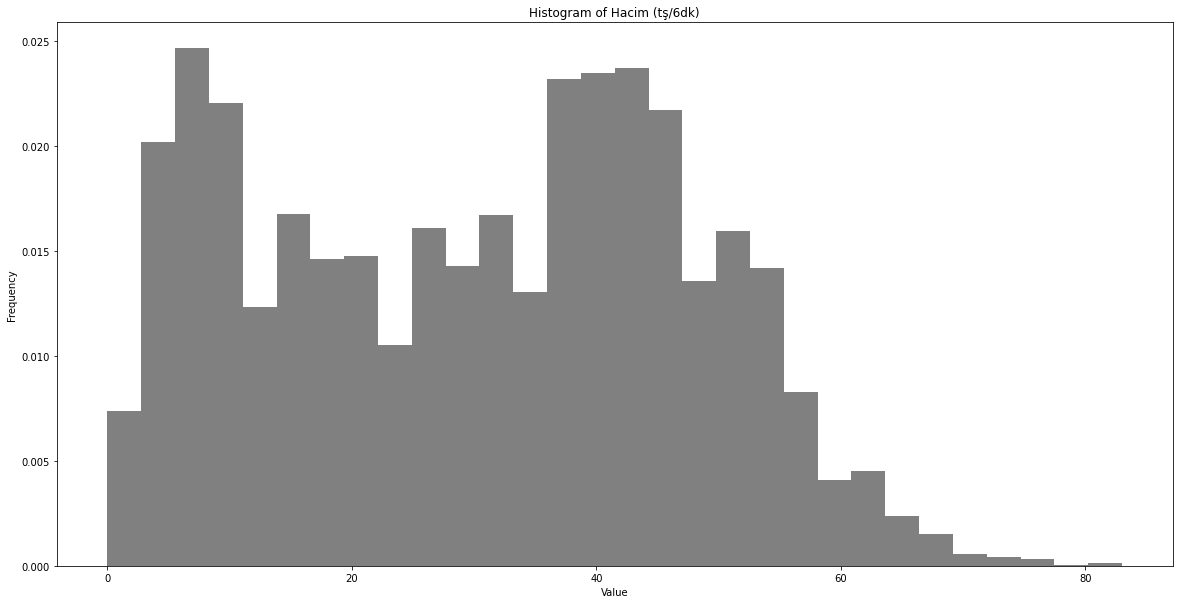

In [11]:
plot_data_distrubution(ex_excel, "Hacim (tş/6dk)")

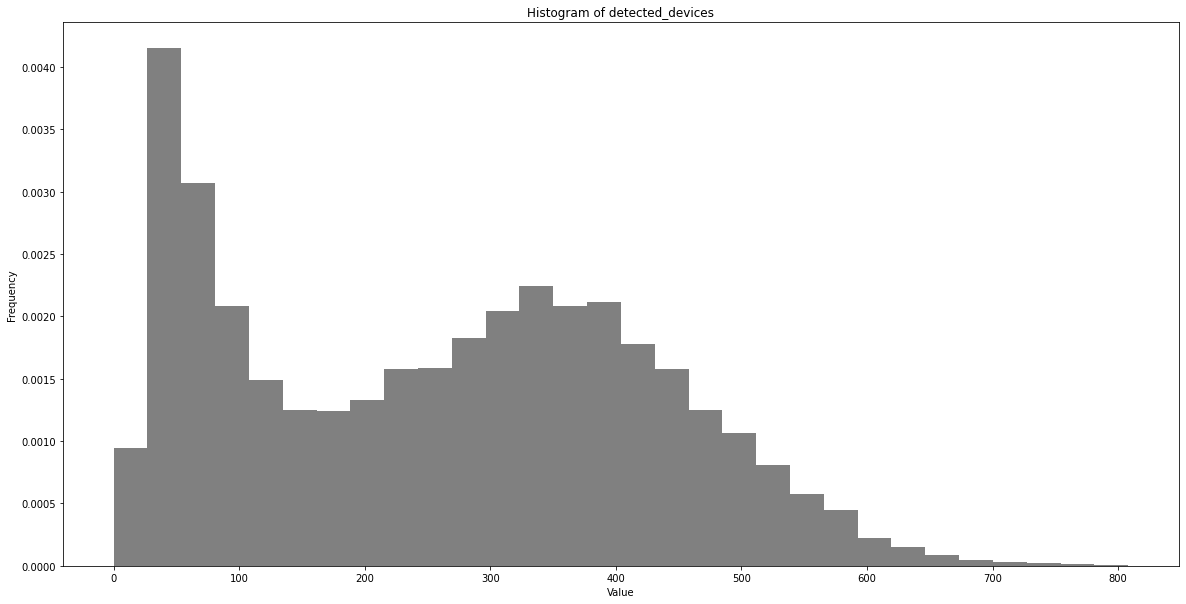

In [12]:
plot_data_distrubution(ex_csv, "detected_devices")

In [16]:
ex_excel.value_counts()

Hacim (tş/6dk)  Hız    Hacim (tş/sa)
0               23.58  0                9
                27.22  0                9
4               37.55  80               6
41              21.53  820              4
7               38.54  140              4
                                       ..
23              30.62  460              1
                30.68  460              1
                30.77  460              1
                30.83  460              1
83              19.13  1660             1
Name: count, Length: 11607, dtype: int64

In [22]:

def monte_carlo_simulation(sample, num_iterations):
    results = []

    for _ in range(num_iterations):
        # Sample from the GMM
        lower, upper = 0, 1

        # Mean and standard deviation of the desired normal distribution
        mean, std = 0.5, 0.1  # Example values

        # Scale parameters for the truncated normal distribution
        a, b = (lower - mean) / std, (upper - mean) / std

        # Generate one sample from the truncated normal distribution
        result = truncnorm(a, b, loc=mean, scale=std).rvs()
        interval_count = 1 / len(sample)
        index = result // interval_count
        #print(result)
        number = sample[int(index)]

        # Perform your specific computations here with the sample
        # For example, you might want to store the sample or compute some function of it
        results.append(number)
    #print(results)
    return int(np.mean(results))

In [23]:
delimiters = "-|:| " 
split_text = datetime(*tuple(int(x) for x in (re.split(delimiters,(ex_csv["Date"][1])))))
split_text

datetime.datetime(2023, 10, 2, 0, 3)

In [24]:
(datetime(*tuple(int(x) for x in (re.split(delimiters,(ex_csv["Date"][2])))))+ timedelta(minutes=3)).strftime("%Y-%m-%d %H:%M:%S")

'2023-10-02 00:09:00'

In [ ]:
def detect_and_fill_missing_vals(df_main, df_copy, trace, index, filled_column_name, model, num_iterations):

    print("INPUT")
    last_element = np.array(df_copy[index])[-1]
    col_index = 0
    def str_to_dt(string):
        dt_obj = datetime(*tuple(int(x) for x in (re.split("-|:| ",(string)))))
        return dt_obj
    
    for date in df_copy[index]:
        if date == last_element :
            break
        if (datetime(*tuple(int(x) for x in (re.split(delimiters,(date)))))+ timedelta(minutes=3))\
                   .strftime("%Y-%m-%d %H:%M:%S") == df_copy[index][trace + 1] :
                     
            col_index += 1
            trace +=1
            continue
        
        else :
            dt_obj = str_to_dt(date)
            sample = [column for obj, column in zip(df_main[index],df_main[filled_column_name]) if str_to_dt(obj).hour == dt_obj.hour]
            print(sample)
            print(monte_carlo_simulation(sample, num_iterations=1000))
            
            print(f"ROW {trace + 1} DOESNT EXISTS")
            new_values = {index : (dt_obj + timedelta(minutes=3))\
                       .strftime("%Y-%m-%d %H:%M:%S"),
                       filled_column_name : str(int(monte_carlo_simulation(sample, num_iterations)))}
            new_row = pd.Series(data=new_values, name=col_index + 1)
            print(new_values)
            df_copy1 = df_copy.iloc[:col_index + 1]
            df_copy2 = df_copy.iloc[col_index + 1:]
            df_copy = pd.concat([df_copy1, pd.DataFrame(new_row).T, df_copy2]).reset_index(drop=True)
            df_copy.index += (trace - col_index) 
            
            splitted_df = pd.DataFrame(df_copy[col_index:])
            df_copy = pd.concat([df_copy[:col_index],\
                                 detect_and_fill_missing_vals(df_main, splitted_df,\
                                        trace,index, filled_column_name, model, num_iterations)])
            
            break
    return df_copy       

In [26]:
num_iterations = 1000

In [29]:
df_filled = detect_and_fill_missing_vals(ex_csv.copy(), ex_csv.copy(), 0, "Date", "detected_devices", gmm_csv, num_iterations)

INPUT
[31, 28, 53, 46, 37, 43, 42, 44, 45, 45, 40, 42, 41, 33, 43, 47, 40, 45, 36, 48, 50, 44, 38, 51, 60, 46, 32, 38, 36, 49, 33, 48, 39, 34, 126, 81, 47, 40, 30, 40, 40, 38, 39, 33, 42, 27, 55, 31, 28, 154, 42, 26, 30, 31, 37, 40, 29, 34, 24, 41, 45, 52, 63, 47, 40, 47, 30, 34, 20, 32, 30, 31, 44, 25, 39, 24, 34, 40, 39, 44, 47, 73, 51, 40, 62, 52, 52, 43, 39, 50, 42, 31, 30, 36, 48, 38, 53, 31, 33, 48, 69, 57, 64, 74, 62, 76, 93, 43, 36, 42, 56, 78, 63, 73, 65, 70, 44, 57, 75, 65, 77, 56, 74, 75, 90, 61, 73, 81, 111, 72, 68, 58, 58, 52, 62, 52, 55, 43, 46, 28, 21, 32, 38, 34, 34, 29, 31, 29, 38, 32, 45, 33, 35, 27, 24, 29, 31, 27, 27, 56, 61, 45, 39, 41, 45, 51, 45, 51, 50, 40, 38, 49, 42, 45, 35, 47, 44, 42, 52, 30, 37, 31, 29, 38, 33, 28, 30, 26, 27, 18, 26, 27, 49, 50, 28, 51, 36, 53, 48, 91, 79, 81, 72, 59, 81, 63, 62, 65, 76, 81, 71, 79, 60, 83, 55, 65, 74, 81, 143, 62, 67, 45, 44, 67, 58, 56, 49, 37, 56, 51, 43, 45, 59, 76, 79, 92, 64, 34, 48, 61, 76, 47, 57, 63, 59, 65, 65, 1

In [ ]:
ex_csv.copy().to_excel("inpuut.xlsx", index=False)

In [ ]:
df_filled.to_excel("output.xlsx", index=False)

In [32]:
ex_csv[13000:]

,Vector,Description,Date,Year,Month,Day,Hour,Minutes,Seconds,detected_devices,...,losstime hours,losstime minutes,losstime seconds,typical_speed,typical_traveltime,typical_losstime,Congestion,wheather_icon,wheather_temp,weather_desc
13000,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-29 02:33:00,2023,10,29,2,33,0,65,...,0,0,7.96,23.94,37.00,14.86,NaN,NaN,NaN,NaN
13001,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-29 02:36:00,2023,10,29,2,36,0,69,...,0,0,11.37,24.08,36.78,14.64,NaN,NaN,NaN,NaN
13002,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-29 02:39:00,2023,10,29,2,39,0,65,...,0,0,16.05,24.16,36.66,14.52,NaN,NaN,NaN,NaN
13003,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-29 02:42:00,2023,10,29,2,42,0,44,...,0,0,16.07,24.23,36.55,14.41,NaN,NaN,NaN,NaN
13004,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-10-29 02:45:00,2023,10,29,2,45,0,85,...,0,0,28.61,24.28,36.48,14.34,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15114,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:30:00,2023,11,2,12,30,0,405,...,0,0,19.77,23.06,38.41,16.27,NaN,NaN,NaN,NaN
15115,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:33:00,2023,11,2,12,33,0,364,...,0,0,8.67,22.74,38.94,16.80,NaN,NaN,NaN,NaN
15116,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:36:00,2023,11,2,12,36,0,414,...,0,0,8.67,22.53,39.31,17.17,NaN,NaN,NaN,NaN
15117,210,VIA NORTE-URZAIZ a PRAZA DA ESTACION,2023-11-02 12:39:00,2023,11,2,12,39,0,470,...,0,0,8.54,22.47,39.42,17.28,NaN,NaN,NaN,NaN
